# MIA attacks on Length-of-Stay predictor, Gated Recurrent Unit with Decay (GRU-D)
## Installation of Packages in Conda

To install the required packages in your conda environment, you can use the following commands:

```bash
conda install h5py
conda install pytables

In [1]:
import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), "../../../"))  # adjust as needed
if project_root not in sys.path:
    sys.path.insert(0, project_root)  # insert at the front to prioritize it


## Train the classifier
### Load the dataset
The dataset is generated by the notebook file `mimic_dataset_prep.ipynb`.

In [2]:
import os
import yaml
import pickle

# Load the config.yaml file
with open("train_config.yaml", "r") as file:
    train_config = yaml.safe_load(file)

# Determine training method and paths
#TODO: DO we want GRUD traning mode in the config file or not?
assert train_config['train']['training_method'] == 'GRUD', "The training config is not set to use GRUD"
use_LR = train_config['train']['training_method'] == 'LR'
data_path = train_config['data']['data_dir']
path = os.path.join(data_path, "LR_data" if use_LR else "GRUD_data")

# File paths
dataset_path = os.path.join(path, "dataset.pkl")
indices_path = os.path.join(path, "indices.pkl")

# Load dataset and indices
if os.path.exists(dataset_path) and os.path.exists(indices_path):
    print("Loading dataset...")
    
    with open(dataset_path, "rb") as f:
        dataset = pickle.load(f)

    with open(indices_path, "rb") as f:
        indices_dict = pickle.load(f)
        train_indices = indices_dict["train_indices"]
        test_indices = indices_dict["test_indices"]
        early_stop_indices = indices_dict["early_stop_indices"]
        #TODO: fix this
        data_indices = train_indices + test_indices + early_stop_indices

    print(f"Loaded dataset and indices from {path}")
else:
    raise FileNotFoundError("Dataset not found.\n→ Run 'mimic_dataset_prep.ipynb' to generate the required dataset.\n")


Loading dataset...


/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Loaded dataset and indices from ./data/GRUD_data


Create dala loaders. The  `batch_size` is one of the parameters which is assigned based on hyperparameter tuning as detailed in [this notebook](https://github.com/MLforHealth/MIMIC_Extract/blob/4daf3c89be7de05d26f47819d68d5532de6f753a/notebooks/Baselines%20for%20Mortality%20and%20LOS%20prediction%20-%20GRU-D.ipynb).

In [3]:
from torch.utils.data import DataLoader
from mimic_data_handler import MIMICUserDataset


data = dataset.data
targets = dataset.targets

train_subset = MIMICUserDataset(data[train_indices], targets[train_indices])
test_subset = MIMICUserDataset(data[test_indices], targets[test_indices])
early_stop_subset = MIMICUserDataset(data[early_stop_indices], targets[early_stop_indices])

# Create DataLoaders
batch_size = 59
train_loader = DataLoader(train_subset, batch_size=batch_size)
test_loader = DataLoader(test_subset, batch_size=batch_size)
early_stop_loader = DataLoader(early_stop_subset, batch_size=batch_size)


The `optimized_hyperparams` is assigned based on hyperparameter tuning as detailed in [this notebook](https://github.com/MLforHealth/MIMIC_Extract/blob/4daf3c89be7de05d26f47819d68d5532de6f753a/notebooks/Baselines%20for%20Mortality%20and%20LOS%20prediction%20-%20GRU-D.ipynb).

In [4]:
optimized_hyperparams ={
    "hidden_size": 78,
    "learning_rate": 0.0000289,
    "num_epochs":37,
    "patience_early_stopping": 40,
    "patience_lr_scheduler": 2,
    "batch_size": batch_size,
    "seed": 4410,
    "min_delta": 0.00001,
    }

In [8]:
from torch import  nn, optim, save, zeros
from mimic_model_handler import GRUHandler
from target_models import GRUD
import os
import pickle

# Add other required parameters to model_params
model_params = {
    "hidden_size": optimized_hyperparams["hidden_size"],
    "batch_size": optimized_hyperparams["batch_size"],
    "input_size": int(data.shape[1]/3),
    "X_mean":  zeros(1,data.shape[2],int(data.shape[1]/3)),
    "output_last": False,
    "bn_flag": True,
}

# Initialize the model with filtered parameters
model = GRUD(**model_params)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=optimized_hyperparams["learning_rate"])

# Train the model
train_results = GRUHandler().train(model,
                                    train_loader,
                                    criterion,
                                    optimizer,
                                    early_stop_loader,
                                    optimized_hyperparams["num_epochs"],
                                    optimized_hyperparams["patience_early_stopping"],
                                    optimized_hyperparams["patience_lr_scheduler"],
                                    optimized_hyperparams["min_delta"],
                                    )

# Evaluate the model
test_results = GRUHandler().eval(test_loader, model, criterion)


# Store model and its metadata
model = train_results.model
model.to("cpu")
target_dir = "target_GRUD"
os.makedirs(target_dir, exist_ok=True)
with open(target_dir+"/target_model.pkl", "wb") as f:
    save(model.state_dict(), f)

# Create metadata to be used by LeakPro
from leakpro import LeakPro
meta_data = LeakPro.make_mia_metadata(train_result = train_results,
                                    optimizer = optimizer,
                                    loss_fn = criterion,
                                    dataloader = train_loader,
                                    test_result = test_results,
                                    epochs = optimized_hyperparams["num_epochs"],
                                    train_indices = train_indices,
                                    test_indices = test_indices,
                                    dataset_name = train_config["data"]["dataset"])

with open(target_dir + "/model_metadata.pkl", "wb") as f:
    pickle.dump(meta_data, f)

Training Progress:   0%|          | 0/37 [00:00<?, ?it/s]

Training Progress:   3%|▎         | 1/37 [00:56<33:46, 56.29s/it]

Epoch 0: Validation loss improved to 2.5487
Learning Rate: 2.000000000000
Epoch: 0, train_loss: 9.6114501, valid_loss: 2.54866994, train_acc: 0.53291012


Epoch 2/37: 100%|██████████| 203/203 [00:09<00:00, 21.97it/s]


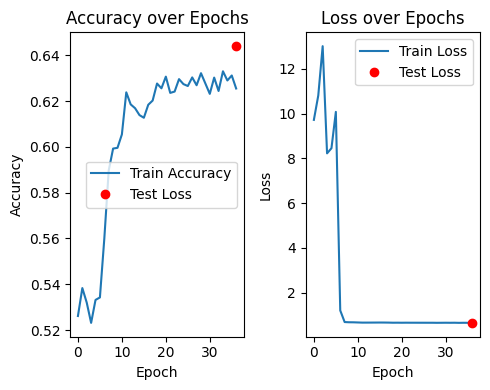

In [6]:
import matplotlib.pyplot as plt

train_acc = train_results.metrics.extra["accuracy_history"]
train_loss = train_results.metrics.extra["loss_history"]
test_acc = test_results.accuracy
test_loss = test_results.loss

# Plot training and test accuracy
plt.figure(figsize=(5, 4))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(len(train_loss)-1, test_acc, 'ro', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

# Plot training and test loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(len(train_loss)-1, test_loss, 'ro', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

##  Attacking the GRUD model
Modify ```audit.yaml ``` file to attack GRUD model: 
  
  ```
  module_path: "utils/model_GRUD.py" 
  model_class: "GRUD"
  target_folder: "./target_GRUD"
  data_path: "./data/GRUD_data/dataset.pkl"
  ```

In [7]:
from mimic_GRUD_handler import MimicInputHandlerGRU

from leakpro import LeakPro

# Read the config file
config_path = "audit.yaml"

# Prepare leakpro object
leakpro = LeakPro(MimicInputHandlerGRU, config_path)

# Run the audit
mia_results = leakpro.run_audit(return_results=True)

ModuleNotFoundError: No module named 'mimic_GRUD_handler'

## Generate report